# UBS Dota2 ML

In [102]:
from __future__ import print_function
from math import sqrt, ceil
from IPython import display
from sklearn import linear_model, metrics, model_selection, datasets, decomposition
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline

# Get Raw Data

In [69]:
df_data = pd.read_excel('all_features_with_time_new.xlsx')

In [70]:
df_data.head()

,match_id,match_duration,radiant_win,radiant_heros,dire_heros,time,radiant_gold_adv,radiant_xp_adv,radiant_gold_adv_diff,radiant_xp_adv_diff,...,dire_all_towers_mask,radiant_all_barracks_mask,dire_all_barracks_mask,radiant_gold_adv_bin*500,radiant_xp_adv_bin *200,radiant_win_rate,similar_games,Unnamed: 20,Unnamed: 21,time slice
0,4116696916,2041,True,"[83, 121, 2, 67, 34]","[71, 22, 42, 79, 113]",0,0,0,0,0,...,11111111111,111111,111111,0,0,0.546,10770,nan,nan,nan
1,4116696916,2041,True,"[83, 121, 2, 67, 34]","[71, 22, 42, 79, 113]",1,-353,-52,-353,-52,...,11111111111,111111,111111,-1,-1,0.507,1644,nan,nan,nan
2,4116696916,2041,True,"[83, 121, 2, 67, 34]","[71, 22, 42, 79, 113]",2,-731,-406,-378,-354,...,11111111111,111111,111111,-2,-3,0.392,245,nan,nan,nan
3,4116696916,2041,True,"[83, 121, 2, 67, 34]","[71, 22, 42, 79, 113]",3,-1144,-585,-413,-179,...,11111111111,111111,111111,-3,-3,0.355,141,nan,nan,nan
4,4116696916,2041,True,"[83, 121, 2, 67, 34]","[71, 22, 42, 79, 113]",4,-993,-703,151,-118,...,11111111111,111111,111111,-2,-4,0.386,215,nan,nan,nan


In [71]:
data = df_data[['time',
                'radiant_gold_adv_bin*500',
                'radiant_xp_adv_bin *200',
                'radiant_win_rate']]

data.rename(columns={"time": "time",
                     "radiant_gold_adv_bin*500": "gold",
                    "radiant_xp_adv_bin *200":"xp",
                    "radiant_win_rate":"target"}, inplace = True)
 
data.head()

,time,gold,xp,target
0,0,0,0,0.546
1,1,-1,-1,0.507
2,2,-2,-3,0.392
3,3,-3,-3,0.355
4,4,-2,-4,0.386


In [72]:
data.describe()

,time,gold,xp,target
count,457826.000,457826.000,457826.000,457826.000
mean,20.076,-0.746,-1.275,0.524
std,13.652,14.973,40.709,0.335
min,0.000,-143.000,-295.000,0.000
25%,9.000,-5.000,-14.000,0.333
50%,19.000,0.000,0.000,0.531
75%,29.000,5.000,13.000,0.750
max,106.000,102.000,300.000,1.000


# Data Cleaning

#### PCA if necessary

#### Shuffle the data

In [73]:
df_data_feature = data.reindex(np.random.permutation(data.index))
df_data_feature.head()

,time,gold,xp,target
360982,7,-9,-11,0.000
248860,40,8,12,0.000
382595,42,54,97,1.000
95938,21,-23,-66,0.000
375128,59,-11,-55,0.000


#### Split training, validation and testing data

In [74]:
data_train, data_test = model_selection.train_test_split(df_data_feature, 
                                                         test_size = 0.2, 
                                                         random_state=1,
                                                         shuffle=True)

data_validation, data_test= model_selection.train_test_split(data_test, 
                                                         test_size = 0.5, 
                                                         random_state=1,
                                                         shuffle=True)
display.display(data_train.describe())
display.display(data_validation.describe())
display.display(data_test.describe())

,time,gold,xp,target
count,366260.000,366260.000,366260.000,366260.000
mean,20.103,-0.752,-1.277,0.524
std,13.664,14.984,40.707,0.335
min,0.000,-143.000,-295.000,0.000
25%,9.000,-5.000,-14.000,0.333
50%,19.000,0.000,0.000,0.531
75%,29.000,5.000,13.000,0.750
max,106.000,102.000,269.000,1.000


,time,gold,xp,target
count,45783.000,45783.000,45783.000,45783.000
mean,19.985,-0.749,-1.362,0.523
std,13.599,14.905,40.732,0.334
min,0.000,-115.000,-268.000,0.000
25%,9.000,-5.000,-14.000,0.333
50%,18.000,0.000,0.000,0.529
75%,29.000,4.000,13.000,0.750
max,95.000,96.000,222.000,1.000


,time,gold,xp,target
count,45783.000,45783.000,45783.000,45783.000
mean,19.954,-0.698,-1.165,0.522
std,13.610,14.954,40.703,0.335
min,0.000,-117.000,-239.000,0.000
25%,9.000,-5.000,-14.000,0.324
50%,18.000,0.000,0.000,0.531
75%,29.000,5.000,13.000,0.750
max,98.000,95.000,300.000,1.000


#### Scaling feature values

In [75]:
feature_columns = ['time', 'gold', 'xp']

In [76]:
scaler = MinMaxScaler()
data_train_copy = data_train[feature_columns].copy()
data_validation_copy = data_validation[feature_columns].copy()
data_test_copy = data_test[feature_columns].copy()

scaler.fit(data_train_copy)
data_train_norm = scaler.transform(data_train_copy)
data_validation_norm = scaler.transform(data_validation_copy)
data_test_norm = scaler.transform(data_test_copy)

In [77]:
data_train_normalize = pd.DataFrame(index = data_train_copy.index, 
                                    columns = data_train_copy.columns, 
                                    data = data_train_norm)
data_validation_normalize = pd.DataFrame(index = data_validation_copy.index, 
                                    columns = data_validation_copy.columns, 
                                    data = data_validation_norm)
data_test_normalize = pd.DataFrame(index = data_test_copy.index, 
                                    columns = data_test_copy.columns, 
                                    data = data_test_norm)

#### Traning, validation and test data set

In [78]:
training_examples = data_train_normalize.copy()
training_targets = data_train['target']

validation_examples = data_validation_normalize.copy()
validation_targets = data_validation['target']

test_examples = data_test_normalize.copy()
test_targets = data_test['target']

In [79]:
display.display(training_examples.describe())
display.display(training_targets.describe())

,time,gold,xp
count,366260.000,366260.000,366260.000
mean,0.190,0.581,0.521
std,0.129,0.061,0.072
min,0.000,0.000,0.000
25%,0.085,0.563,0.498
50%,0.179,0.584,0.523
75%,0.274,0.604,0.546
max,1.000,1.000,1.000


count   366260.000
mean         0.524
std          0.335
min          0.000
25%          0.333
50%          0.531
75%          0.750
max          1.000
Name: target, dtype: float64

# Linear Regression

In [80]:
regr_linear = linear_model.LinearRegression()
regr_linear.fit(training_examples, training_targets)

training_pred = regr_linear.predict(training_examples)
validation_pred = regr_linear.predict(validation_examples)
test_pred = regr_linear.predict(test_examples)

RMSE_training_linear = np.sqrt(metrics.mean_squared_error(training_targets, training_pred))
RMSE_validation_linear = np.sqrt(metrics.mean_squared_error(validation_targets, validation_pred))
RMSE_test_linear = np.sqrt(metrics.mean_squared_error(test_targets, test_pred))

print('RMSE_training:', RMSE_training_linear)
print('RSME_validation:', RMSE_validation_linear)
print('RSME_test:', RMSE_test_linear)

RMSE_training: 0.2502420340702963
RSME_validation: 0.2505042629159924
RSME_test: 0.2499953379676684


# RandomForestRegressor

In [81]:
regr_rf = RandomForestRegressor(max_depth=5, random_state=0)
regr_rf.fit(training_examples, training_targets)

training_pred = regr_rf.predict(training_examples)
validation_pred = regr_rf.predict(validation_examples)
test_pred = regr_rf.predict(test_examples)

RMSE_training_rf = np.sqrt(metrics.mean_squared_error(training_targets, training_pred))
RMSE_validation_rf = np.sqrt(metrics.mean_squared_error(validation_targets, validation_pred))
RMSE_test_rf = np.sqrt(metrics.mean_squared_error(test_targets, test_pred))

print('RMSE_training:', RMSE_training_rf)
print('RSME_validation:', RMSE_validation_rf)
print('RSME_test:', RMSE_test_rf)

RMSE_training: 0.2352489171030932
RSME_validation: 0.23527859742025176
RSME_test: 0.23498068571075525


# DNN

In [82]:
# define feature column
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

# define input function
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

#### Define Deep Learning Neural Net work model

In [83]:
# define DNN model
def train_nn_regression_model(
    my_optimizer,
    steps,
    periods,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    steps_per_period = steps / periods
    
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=my_optimizer)
    
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets, 
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                    training_targets, 
                                                    num_epochs=1, 
                                                    shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                      validation_targets, 
                                                      num_epochs=1, 
                                                      shuffle=False)
    print ("Training model...")
    print ("RMSE (on training data & validation data):")
    training_rmse = []
    validation_rmse = []
    validation_pred_set = []

    for period in range (0, periods):
        dnn_regressor.train(input_fn=training_input_fn,
                            steps=steps_per_period)
        
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
        training_RSME = sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_RSME = sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
    
        print ("  period %02d : %0.5f \t %0.5f" % (period, training_RSME, validation_RSME))
        
        training_rmse.append(training_RSME)
        validation_rmse.append(validation_RSME)
        validation_pred_set.append(validation_predictions)
    
    print ("Model training finished.")
    print ("Final RMSE (on training data):   %0.5f" % training_rmse[-1])
    print ("Final RMSE (on validation data): %0.5f" % validation_rmse[-1])
    return dnn_regressor, training_rmse, validation_rmse, validation_pred_set

#### Build hidden layers

In [84]:
# Determine length of first layer
layer1_length = 1
while True:
    layer1_length *= 2
    if layer1_length > 2*len(feature_columns):
        break

In [85]:
# Define 3 layers of DNN
neurons_1 = layer1_length
neurons_2 = int(neurons_1/2)
neurons_3 = int(neurons_2/2)
hidden_units = [neurons_1, neurons_2, neurons_3]
hidden_units

[8, 4, 2]

#### Training and Validation

In [86]:
batch_size = 1000
steps = 2000
learning_rate = 0.0005

In [87]:
dnn_regressor, adam_training_losses, adam_validation_losses, \
validation_pred_set = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
    steps=steps,
    periods=10,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data & validation data):
  period 00 : 0.54009 	 0.53909
  period 01 : 0.46491 	 0.46393
  period 02 : 0.39857 	 0.39765
  period 03 : 0.34249 	 0.34170
  period 04 : 0.30028 	 0.29961
  period 05 : 0.27244 	 0.27188
  period 06 : 0.25571 	 0.25519
  period 07 : 0.24696 	 0.24646
  period 08 : 0.24237 	 0.24188
  period 09 : 0.24000 	 0.23952
Model training finished.
Final RMSE (on training data):   0.24000
Final RMSE (on validation data): 0.23952


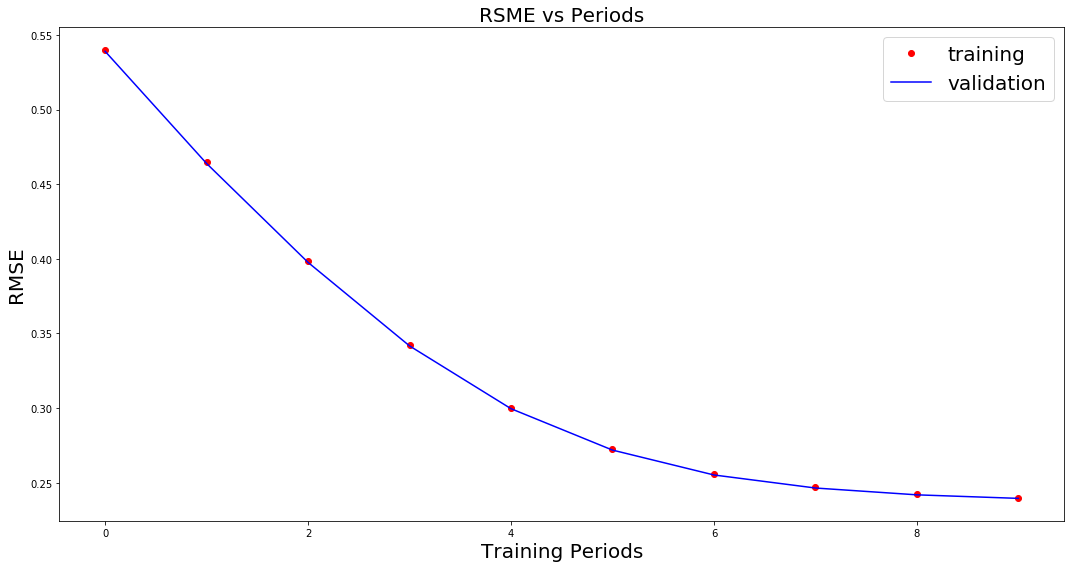

In [92]:
# Output a graph of loss metrics over periods.
plt.figure(figsize = (15,8))
plt.ylabel("RMSE", fontsize = 20)
plt.xlabel("Training Periods", fontsize = 20)
plt.title("RSME vs Periods", fontsize = 20)
plt.tight_layout()
plt.plot(adam_training_losses, 'ro', label="training")
plt.plot(adam_validation_losses, 'b-', label="validation")
plt.legend(fontsize = 20)
plt.show()

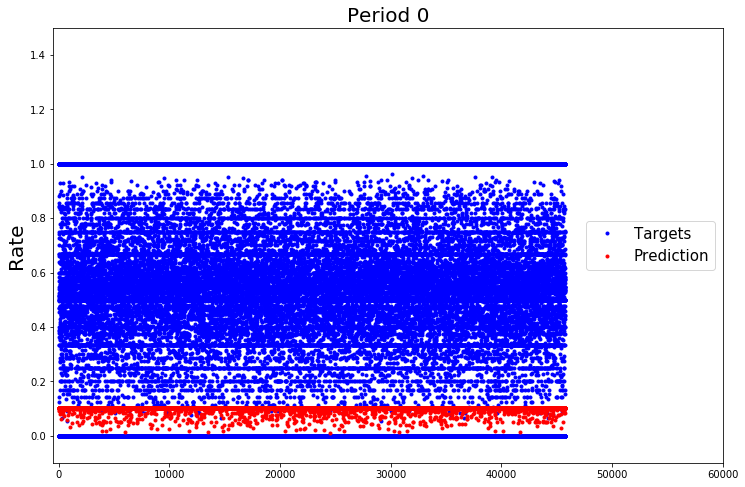

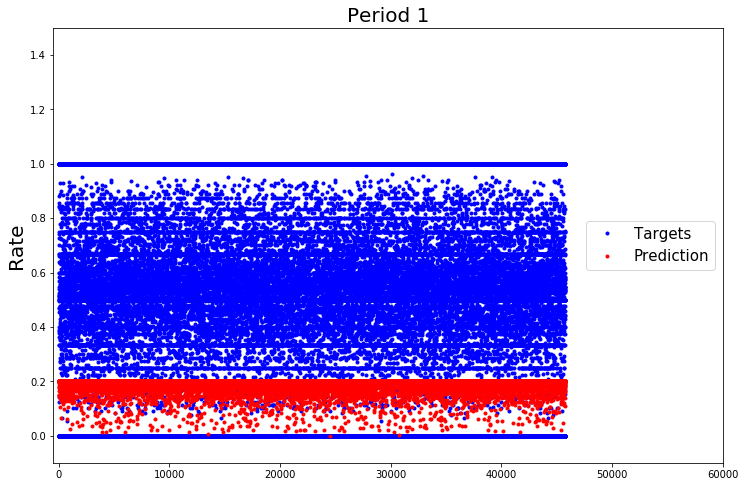

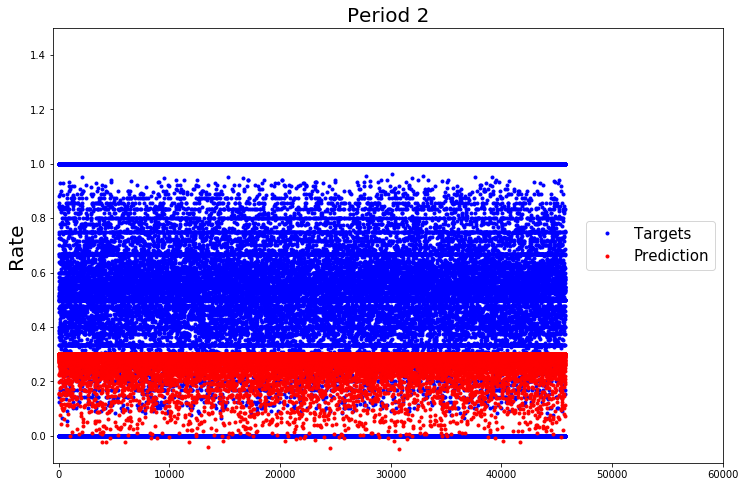

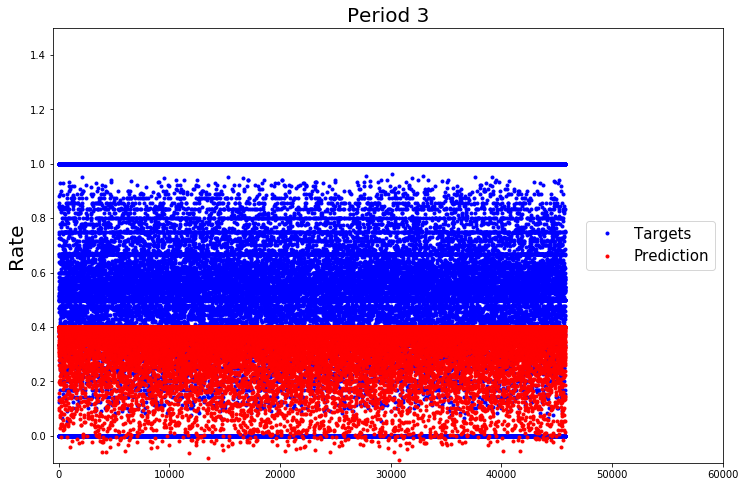

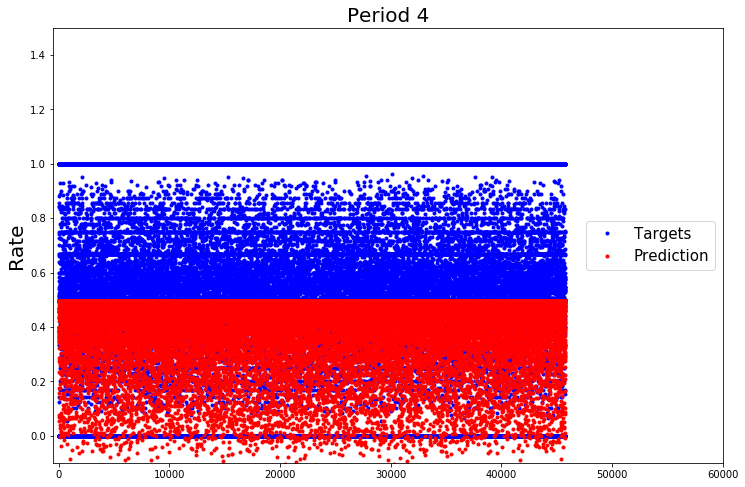

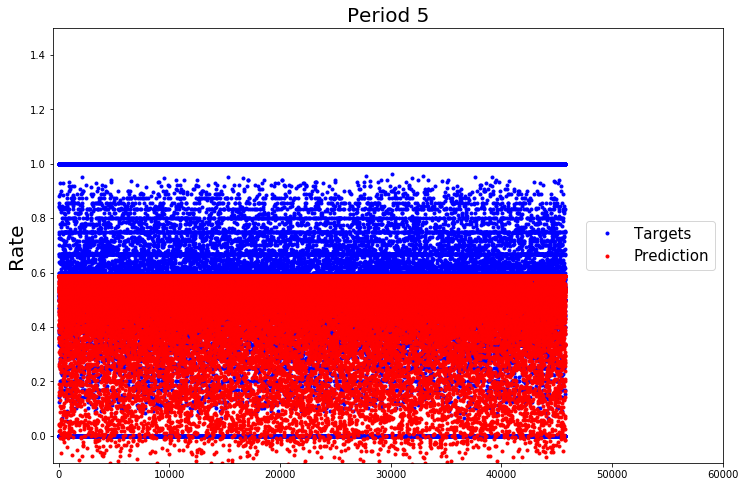

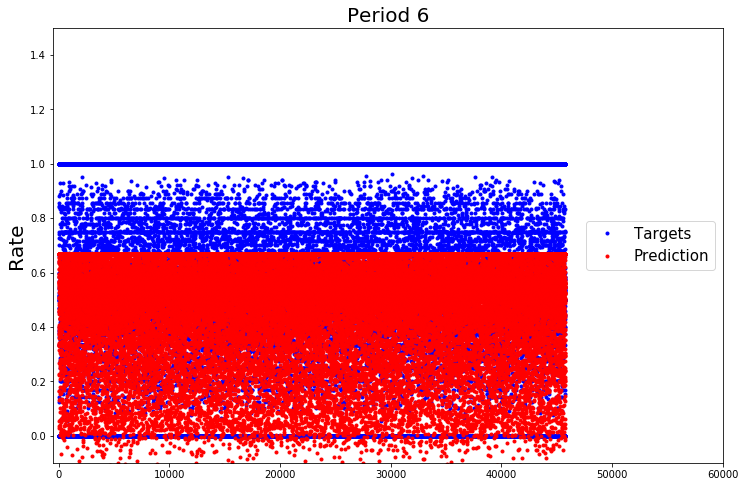

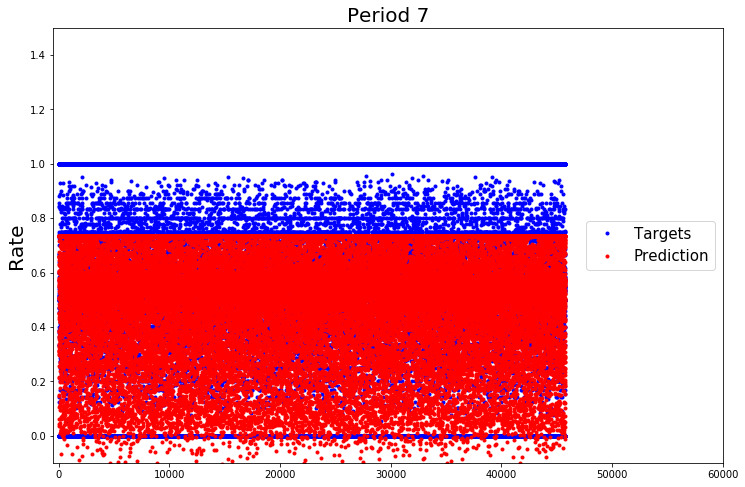

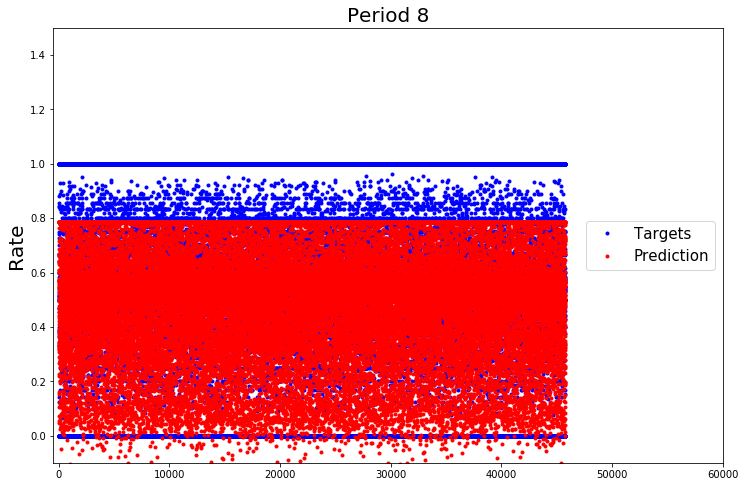

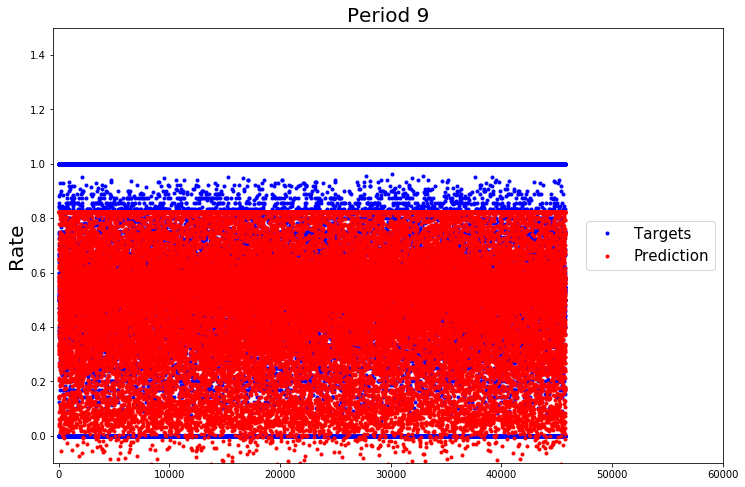

In [94]:
for i in range(len(validation_pred_set)):
    plt.figure(figsize = (12,8))
    plt.axis([-500, 60000, -0.1, 1.5])
    plt.plot(validation_targets.values, 'b.')
    plt.plot(validation_pred_set[i], 'r.')
    plt.legend(('Targets', 'Prediction'),loc = 'center right', fontsize = 15)
    plt.title('Period ' + str(i), fontsize = 20)
    plt.ylabel("Rate", fontsize = 20)
    plt.show()

#### Test DNN model

In [95]:
predict_test_input_fn = lambda: my_input_fn(test_examples, 
                                            test_targets, 
                                            num_epochs=1, 
                                            shuffle=False)

test_pred = dnn_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_pred])
    
# Compute test RMSE.
adam_test_losses = sqrt(metrics.mean_squared_error(test_predictions, test_targets))

# Model Metrics Summary

In [103]:
df_RMSE = pd.DataFrame()

df_RMSE.loc['RMSE_of_Training', 'Linear'] = RMSE_training_linear
df_RMSE.loc['RMSE_of_Validation', 'Linear'] = RMSE_validation_linear
df_RMSE.loc['RMSE_of_Test', 'Linear'] = RMSE_test_linear

df_RMSE.loc['RMSE_of_Training', 'Random Forest'] = RMSE_training_rf
df_RMSE.loc['RMSE_of_Validation', 'Random Forest'] = RMSE_validation_rf
df_RMSE.loc['RMSE_of_Test', 'Random Forest'] = RMSE_test_rf

df_RMSE.loc['RMSE_of_Training', 'DNN'] = adam_training_losses[-1]
df_RMSE.loc['RMSE_of_Validation', 'DNN'] = adam_validation_losses[-1]
df_RMSE.loc['RMSE_of_Test', 'DNN'] = adam_test_losses

df_RMSE.loc['RMSE_of_Training', '% of Mean(DNN)'] = \
100*adam_training_losses[-1]/np.mean(training_targets)
df_RMSE.loc['RMSE_of_Validation', '% of Mean(DNN)'] = \
100*adam_validation_losses[-1]/np.mean(validation_targets)
df_RMSE.loc['RMSE_of_Test', '% of Mean(DNN)'] = \
100*adam_test_losses/np.mean(test_targets)
    
df_RMSE

,Linear,Random Forest,DNN,% of Mean(DNN)
RMSE_of_Training,0.25024,0.23525,0.24000,45.81275
RMSE_of_Validation,0.25050,0.23528,0.23952,45.77916
RMSE_of_Test,0.25000,0.23498,0.23966,45.88399
